In [1]:
import sys, os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

print("Python version is: " + sys.version)
print("Tensorflow version is: " + tf.__version__)

Python version is: 3.11.2 (main, Mar 27 2023, 23:42:44) [GCC 11.2.0]
Tensorflow version is: 2.12.0


# Defining the dataset

In [2]:
import random

dataset_path = "custom_face_database"

files = [os.path.join(r,file) for r,d,f in os.walk(dataset_path) for file in f]

file_size = len(files)

print("We have " + str(file_size) + " images.")

random.shuffle(files)

We have 750 images.


## generating classes and labels

Let's define the label for each class

In [3]:
import numpy as np

def make_instances(files, classes = []):
    labels = []
    for i in range(len(files)):
        file = files[i]
        clazz = file.split("/")[-2]
        
        if classes.count(clazz):
            label = classes.index(clazz)
        else:
            label = len(classes)
            classes.append(clazz)

        labels.append(label)

    return np.array(labels), np.array(classes)

labels, classes = make_instances(files)
CLASSES_SIZE = len(classes)

print(str(CLASSES_SIZE) + " classes: ", classes)

15 classes:  ['obama' 'brad_pitt' 'megan_rapinoe' 'meryl_streep' 'chris_emsworth'
 'messi' 'bia_miranda' 'katty_perry' 'elon_musk' 'priyanka_chopra'
 'idris_elba' 'mbappe' 'angelababy' 'nicolas_cage' 'lula']


## generating class-balanced training and validation sets

Here the idea is generating the training and validation set in such way 80% of files of each class are within the training data and the remaining 20% are in the validation data.

In [4]:
training_files = []
training_labels = []
validation_files = []
validation_labels = []

for label in range(CLASSES_SIZE):
    indexes = np.where(labels == label)[0]

    threshold = len(indexes) * 80 // 100

    training_indexes = indexes[0:threshold]
    training_files_for_class = [files[i] for i in training_indexes]

    training_files.extend(training_files_for_class)
    training_labels.extend([label] * len(training_files_for_class))

    validation_indexes = indexes[threshold:]
    validation_files_for_class = [files[i] for i in validation_indexes]

    validation_files.extend(validation_files_for_class)
    validation_labels.extend([label] * len(validation_files_for_class))

In [5]:
print(classes)

print(len(training_files))
print(len(training_labels))
print(len(validation_files))
print(len(validation_labels))

print(training_files[0:4])
print(training_labels[0:4])

print(validation_files[0:4])
print(validation_labels[0:4])

['obama' 'brad_pitt' 'megan_rapinoe' 'meryl_streep' 'chris_emsworth'
 'messi' 'bia_miranda' 'katty_perry' 'elon_musk' 'priyanka_chopra'
 'idris_elba' 'mbappe' 'angelababy' 'nicolas_cage' 'lula']
600
600
150
150
['custom_face_database/obama/Selection_020 (1).png', 'custom_face_database/obama/Selection_017 (1).png', 'custom_face_database/obama/Selection_024 (2).png', 'custom_face_database/obama/Selection_015 (2).png']
[0, 0, 0, 0]
['custom_face_database/obama/Selection_025 (2).png', 'custom_face_database/obama/Selection_018 (2).png', 'custom_face_database/obama/Selection_016 (1).png', 'custom_face_database/obama/Selection_021 (1).png']
[0, 0, 0, 0]


In [6]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []

    n = min([len(digit_indices[d]) for d in range(CLASSES_SIZE)]) - 1
    
    for d in range(CLASSES_SIZE):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, CLASSES_SIZE)
            dn = (d + inc) % CLASSES_SIZE
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(CLASSES_SIZE)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

In [7]:
training_files = np.array(training_files)
training_labels = np.array(training_labels)

validation_files = np.array(validation_files)
validation_labels = np.array(validation_labels)

In [8]:

training_pairs, training_pairs_labels = create_pairs_on_set(training_files, training_labels)
validation_pairs, validation_pairs_labels = create_pairs_on_set(validation_files, validation_labels)

In [9]:
print(len(training_files))
print(len(validation_files))
print(len(training_pairs))
print(len(validation_pairs))

600
150
1170
270


## Creating training & validation datasets

## Data augmentation

As any machine learning model, Siamese Networks are also prone to overfitting or underfitting. In order to avoid overfitting almost as possible, we will introduce augmented data as follows:

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.01),
    tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0., 1.)),
    tf.keras.layers.GaussianNoise(0.002)
])

In [11]:
INPUT_SIZE = 244
TRAINING_BATCH_SIZE = 8

def load_image(file_name):
    raw = tf.io.read_file(file_name)
    image = tf.io.decode_image(raw, expand_animations = False, channels=3)
    image = tf.image.resize(image, size=(INPUT_SIZE, INPUT_SIZE), preserve_aspect_ratio=True)
    image = tf.image.resize_with_crop_or_pad(image, INPUT_SIZE, INPUT_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_images(pair):
    img_A = load_image(pair[0])
    img_B = load_image(pair[1])
    return (img_A, img_B)

def build_training_dataset():

    pairs_tensor = tf.convert_to_tensor(training_pairs)
    labels_tensor = tf.convert_to_tensor(training_pairs_labels)

    result = tf.data.Dataset.from_tensor_slices((pairs_tensor, labels_tensor))

    result = result.map(lambda pair, label: (load_images(pair), label))
    result = result.shuffle(100, reshuffle_each_iteration=True)
    result = result.repeat()
    result = result.batch(TRAINING_BATCH_SIZE)
    result = result.map(lambda pair, y: ((data_augmentation(pair[0], training=True),data_augmentation(pair[1], training=True)), y), 
                num_parallel_calls=tf.data.AUTOTUNE)

    result = result.prefetch(tf.data.AUTOTUNE)

    return result

train_ds = build_training_dataset()


In [12]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, instances, batch_size, rows_per_image):

    img_size = 1

    fig = plt.figure(layout='constrained', figsize=(img_size*2, img_size*rows_per_image))
    subfigs = fig.subfigures(rows_per_image, img_size, wspace=0.07)
    subfigs = subfigs.flatten()
    row = 0
    for images, labels in dataset.take(instances):

        for i in range(batch_size):

            img_A = (images[0][i].numpy()*255).astype("uint8")
            img_B = (images[1][i].numpy()*255).astype("uint8")
            label = labels[i].numpy()

            axs = subfigs[row % rows_per_image].subplots(1, 2, sharey=True)

            axs[0].imshow(img_A)
            axs[0].axis("off")
            axs[1].imshow(img_B)
            axs[1].axis("off")

            subfigs[row % rows_per_image].suptitle(str(label), fontsize=8)
            row += 1
            if row % rows_per_image == 0:
                fig
                fig = plt.figure(layout='constrained', figsize=(img_size*2, img_size*rows_per_image))
                subfigs = fig.subfigures(rows_per_image, img_size, wspace=0.07)
                subfigs = subfigs.flatten()

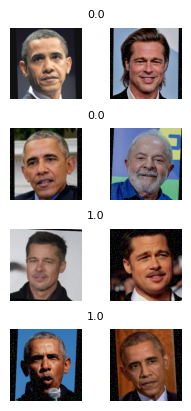

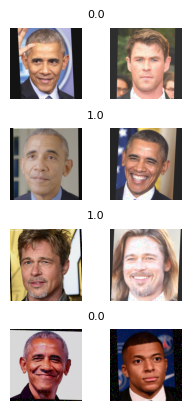

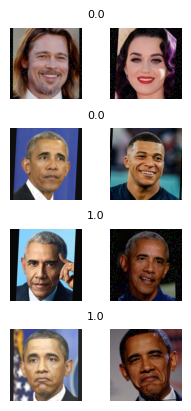

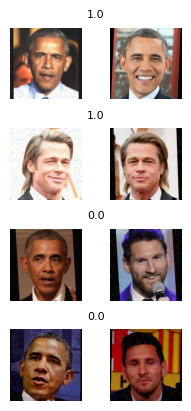

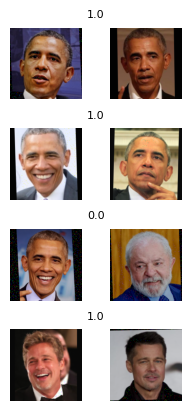

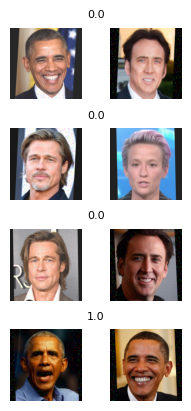

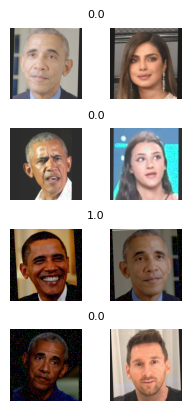

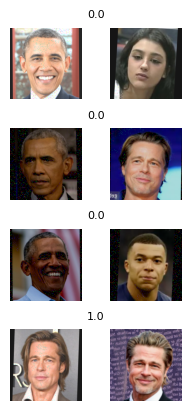

<Figure size 200x400 with 0 Axes>

In [13]:
visualize_dataset(train_ds, 4, TRAINING_BATCH_SIZE, 4)

In [14]:
VALIDATION_BATCH_SIZE = 2

def build_validation_dataset():

    pairs_tensor = tf.convert_to_tensor(validation_pairs)
    labels_tensor = tf.convert_to_tensor(validation_pairs_labels)

    result = tf.data.Dataset.from_tensor_slices((pairs_tensor, labels_tensor))

    result = result.map(lambda pair, label: (load_images(pair), label))
    result = result.batch(VALIDATION_BATCH_SIZE)
    result = result.prefetch(tf.data.AUTOTUNE)

    return result

validation_ds = build_validation_dataset()

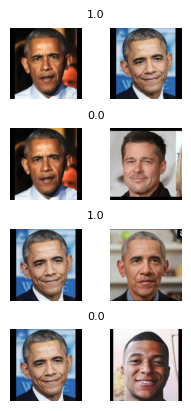

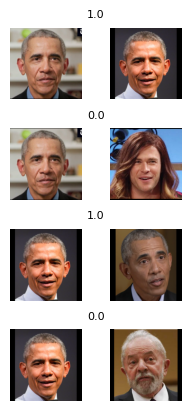

<Figure size 200x400 with 0 Axes>

In [15]:
visualize_dataset(validation_ds, 4, VALIDATION_BATCH_SIZE, 4)

# Defining the model

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

In [17]:
INPUT_SHAPE = (INPUT_SIZE, INPUT_SIZE, 3)

def initialize_base_network():

    inputs = tf.keras.layers.Input(INPUT_SHAPE)
    # base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    base_model = tf.keras.applications.resnet50.ResNet50(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    
    base_model.trainable = True
    fine_tune_at = len(base_model.layers)-int(len(base_model.layers)*.10)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
          
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs=tf.keras.layers.Dense(64)(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [18]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [19]:
def buid_model():
    
    base_network = initialize_base_network()

    input_a = Input(shape=INPUT_SHAPE, name="left_input")
    vect_output_a = base_network(input_a)

    input_b = Input(shape=INPUT_SHAPE, name="right_input")
    vect_output_b = base_network(input_b)

    output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

    return Model([input_a, input_b], output)

In [20]:
model = buid_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 64)           23718848    ['left_input[0][0]',             
                                                                  'right_input[0][0]']      

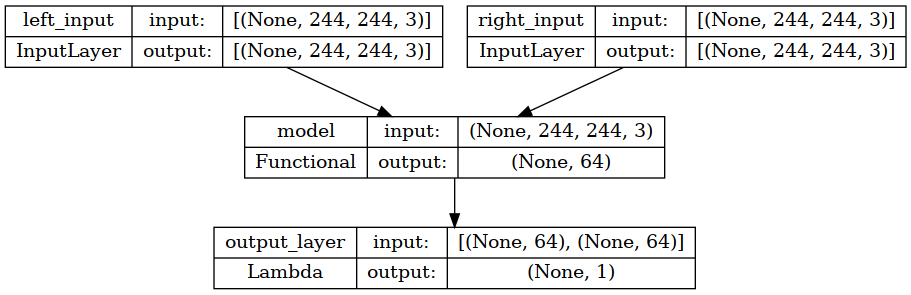

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

# Training

## Defining contrastive_loss

In [22]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

## Defining custom performance metrics

In [23]:
class Precision(tf.keras.metrics.Metric):

  def __init__(self, name='precision', **kwargs):
    super(Precision, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')
    self.false_positives = self.add_weight(name='fp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.math.less(y_pred, 0.5) 

    true_positives_values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    true_positives_values = tf.cast(true_positives_values, self.dtype)

    false_positives_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
    false_positives_values = tf.cast(false_positives_values, self.dtype)

    if sample_weight is not None:
      true_positives_sample_weight = tf.cast(sample_weight, self.dtype)
      true_positives_sample_weight = tf.broadcast_to(true_positives_sample_weight, true_positives_values.shape)
      true_positives_values = tf.multiply(true_positives_values, true_positives_sample_weight)

      false_positives_sample_weight = tf.cast(sample_weight, self.dtype)
      false_positives_sample_weight = tf.broadcast_to(false_positives_sample_weight, false_positives_values.shape)
      false_positives_values = tf.multiply(false_positives_values, false_positives_sample_weight)

    self.true_positives.assign_add(tf.reduce_sum(true_positives_values))
    self.false_positives.assign_add(tf.reduce_sum(false_positives_values))

  def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)

  def result(self):
    result = self.true_positives / (self.true_positives + self.false_positives)
    return result

class Recall(tf.keras.metrics.Metric):

  def __init__(self, name='recall', **kwargs):
    super(Recall, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')
    self.false_negatives = self.add_weight(name='fn', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.math.less(y_pred, 0.5) 

    true_positives_values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    true_positives_values = tf.cast(true_positives_values, self.dtype)

    false_negatives_values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
    false_negatives_values = tf.cast(false_negatives_values, self.dtype)

    if sample_weight is not None:
      true_positives_sample_weight = tf.cast(sample_weight, self.dtype)
      true_positives_sample_weight = tf.broadcast_to(true_positives_sample_weight, true_positives_values.shape)
      true_positives_values = tf.multiply(true_positives_values, true_positives_sample_weight)

      false_negatives_sample_weight = tf.cast(sample_weight, self.dtype)
      false_negatives_sample_weight = tf.broadcast_to(false_negatives_sample_weight, false_negatives_values.shape)
      false_negatives_values = tf.multiply(false_negatives_values, false_negatives_sample_weight)

    self.true_positives.assign_add(tf.reduce_sum(true_positives_values))
    self.false_negatives.assign_add(tf.reduce_sum(false_negatives_values))

  def reset_state(self):
        self.true_positives.assign(0)
        self.false_negatives.assign(0)

  def result(self):
    result = self.true_positives / (self.true_positives + self.false_negatives)
    return result

In [24]:
EPOCHS = 100

model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=tf.keras.optimizers.RMSprop(),
              metrics=[Precision(), Recall()])

history = model.fit(train_ds, steps_per_epoch=(len(training_pairs) // TRAINING_BATCH_SIZE),
                    validation_data=validation_ds,
                    epochs=EPOCHS)

Epoch 1/100
146/146 [==============================] - 32s 142ms/step - loss: 0.3118 - precision: 0.5020 - recall: 0.6507 - val_loss: 0.3154 - val_precision: 0.4821 - val_recall: 0.4000
Epoch 2/100
146/146 [==============================] - 18s 123ms/step - loss: 0.2654 - precision: 0.5213 - recall: 0.6507 - val_loss: 0.2936 - val_precision: 0.4867 - val_recall: 0.5407
Epoch 3/100
146/146 [==============================] - 18s 123ms/step - loss: 0.2523 - precision: 0.5545 - recall: 0.6735 - val_loss: 0.3599 - val_precision: 0.5234 - val_recall: 0.4148
Epoch 4/100
146/146 [==============================] - 18s 123ms/step - loss: 0.2410 - precision: 0.5826 - recall: 0.6860 - val_loss: 0.4378 - val_precision: 0.4933 - val_recall: 0.2741
Epoch 5/100
146/146 [==============================] - 18s 124ms/step - loss: 0.2376 - precision: 0.6009 - recall: 0.6911 - val_loss: 0.2809 - val_precision: 0.5366 - val_recall: 0.4889
Epoch 6/100
146/146 [==============================] - 18s 123ms/step 

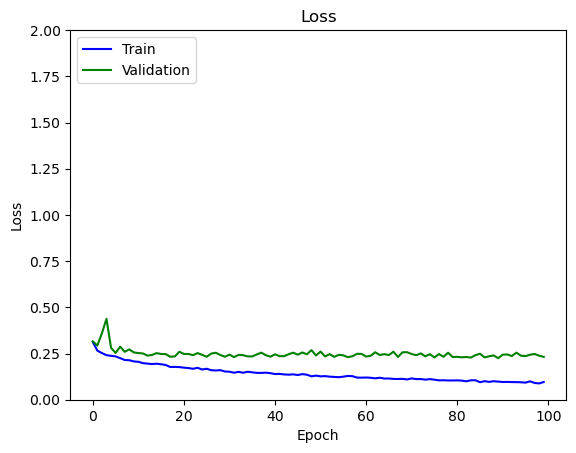

In [25]:
plt.title('Loss')
plt.ylim(0, 2.)
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='green', label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
def compute_performance(y_true, y_pred):

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for actual, distance in zip(y_true, y_pred):
        if actual > 0 and distance < .5:
            TP += 1
        elif actual > 0 and distance >= .5:
            FN += 1
        elif actual < 1 and distance < .5:
            FP += 1
        elif actual < 1 and distance >= .5:
            TN += 1

    precision = float('nan')
    recall = float('nan')
    if (TP + FP) > 0 :
        precision = TP / (TP + FP)
    if (TP + FN) > 0 :
        recall = TP / (TP + FN)

    return precision, recall, TP, TN, FP, FN

In [27]:

import numpy as np

loss = model.evaluate(validation_ds)

y_pred_test = model.predict(validation_ds)

test_y = np.concatenate([y for x, y in validation_ds], axis=0)
test_precision, test_recall, TP, TN, FP, FN = compute_performance(test_y, y_pred_test)

print("Test Loss = {}, Test Precision = {}, Test Recall = {}".format(loss, test_precision, test_recall))
print("TP = {}, TN = {}, FP = {}, FN = {}".format(TP, TN, FP, FN))

135/135 [==============================] - 4s 24ms/step
Test Loss = [0.23190702497959137, 0.71875, 0.5111111402511597], Test Precision = 0.71875, Test Recall = 0.5111111111111111
TP = 69, TN = 108, FP = 27, FN = 66


In [28]:
def visualize_test_pairs(rows_per_image = 10, test_instances = 10):

    fig = plt.figure(layout='constrained', figsize=(2*2, 2*rows_per_image))
    subfigs = fig.subfigures(rows_per_image, 1, wspace=0.07)
    subfigs = subfigs.flatten()
    row = 0
    for images, labels in validation_ds.take(test_instances):

        predictions = model.predict(images)
        for i in range(VALIDATION_BATCH_SIZE):

            axs = subfigs[row % rows_per_image].subplots(1, 2, sharey=True)

            img_A = (images[0][i].numpy()*255).astype("uint8")
            img_B = (images[1][i].numpy()*255).astype("uint8")
            label = labels[i].numpy()

            prediction = predictions[i][0]
        
            bgcolor = (1, 1, 1)
            if (label > 0 and prediction >= 0.5) or (label < 1 and prediction < 0.5):
                bgcolor = (1, 0, 0)

            axs[0].imshow(img_A)
            axs[0].axis("off")
            axs[1].imshow(img_B)
            axs[1].axis("off")
            title_fmt = "Distance is {distance:.4f} for {similarity} images"
            if label > 0:
                title = title_fmt.format(distance = prediction, similarity = "SIMILAR")
            else:
                title = title_fmt.format(distance = prediction, similarity = "different")

            subfigs[row % rows_per_image].suptitle(title, fontsize=8)
            row += 1
            if row % rows_per_image == 0:
                fig
                fig = plt.figure(layout='constrained', figsize=(2*2, 2*rows_per_image))
                subfigs = fig.subfigures(rows_per_image, 1, wspace=0.07)
                subfigs = subfigs.flatten()

1/1 [==============================] - 0s 17ms/step


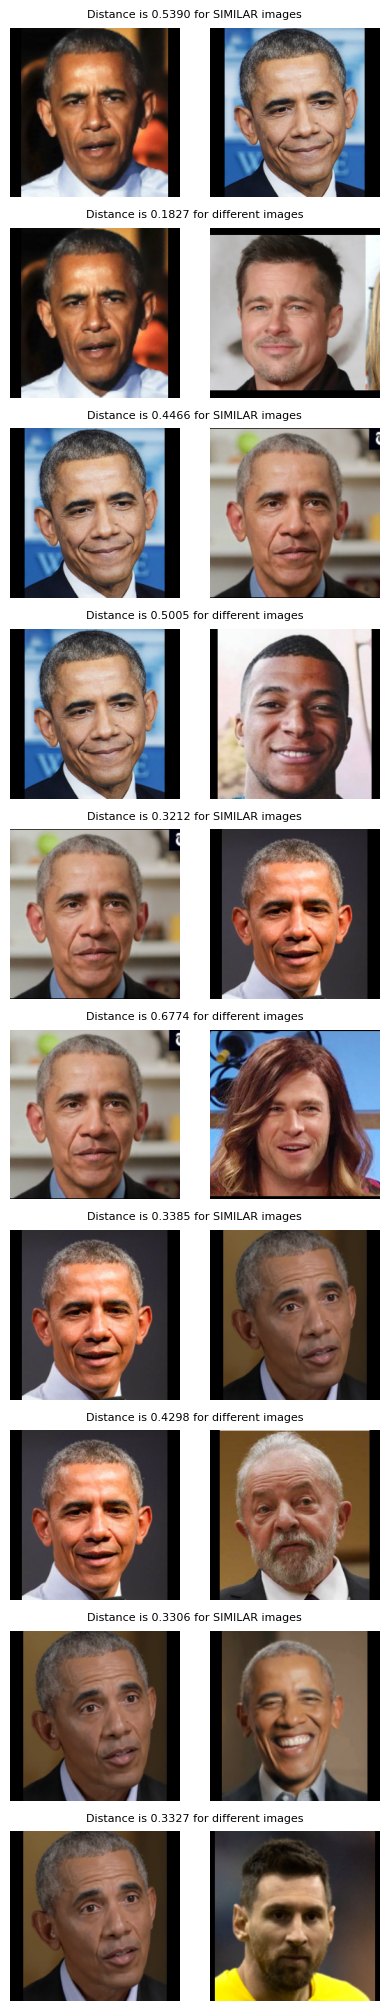

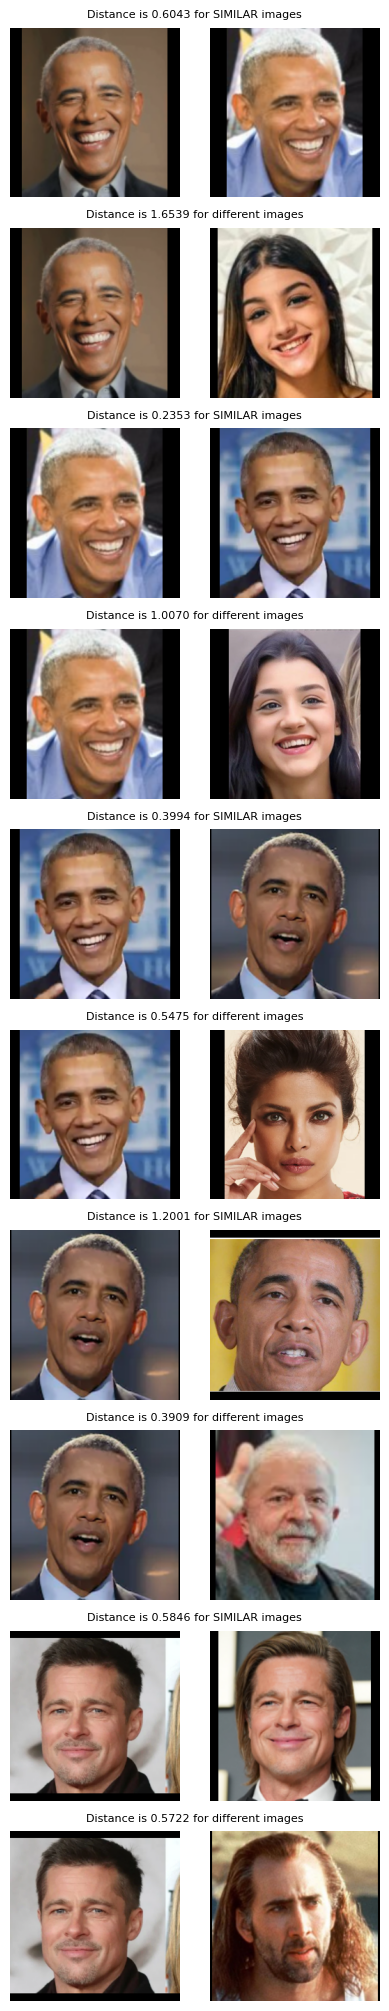

<Figure size 400x2000 with 0 Axes>

In [29]:
visualize_test_pairs()